# Transfer Learning - Fashion MNIST

Transfer Learning allows us to learn faster from a pre-trained model (on a similiar problem) by getting the feature transformation part

There are two ways to do this
- Get the prediction from the feature transformer and use that as an input to a new classifier.
- Make the feature transformation from the pre-trained model false and only train the classifier.

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import vis

Using TensorFlow backend.


### Get Data 

In [2]:
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
labels = vis.fashion_mnist_label()

**Step 1: Prepare the images and labels**

In [4]:
# Reshape data for convlution netowkr
x_train_conv = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_conv = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Convert from 'uint8' to 'float32' and normalise the data to (0,1) 
x_train_conv =  x_train_conv.astype("float32") / 255
x_test_conv = x_test_conv.astype("float32") / 255

# convert class vectors to binary class matrices
y_train_class = keras.utils.to_categorical(y_train, 10)
y_test_class = keras.utils.to_categorical(y_test, 10)

Resize the image for the transfer learning model

Lets resize the image from (28,28,1) to (48,48,3)

In [5]:
from skimage.transform import resize

In [6]:
def resize_image(image):
    return resize(image, (96,96,3), mode="symmetric")

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


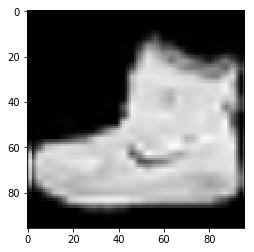

In [7]:
plt.imshow(resize_image(x_train_conv[0]));

Lets resize the 10000 images in train and test data

In [8]:
%timeit
x_train_conv_resize = np.array([resize_image(x_train_conv[x]) for x in range(x_train_conv[:10000].shape[0])])
x_train_conv_resize.shape

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(10000, 96, 96, 3)

In [9]:
%timeit
x_test_conv_resize = np.array([resize_image(x_test_conv[x]) for x in range(x_test_conv.shape[0])])
x_test_conv_resize.shape

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(10000, 96, 96, 3)

**Step 2: Load a pre-trained model for the feature transfomation and add classifier model **

Let us load the VGG model without the classifier layer and **do not** train the weights

In [10]:
from keras.applications.vgg16 import VGG16

In [11]:
conv_base = VGG16(include_top=False, weights='imagenet', 
                        input_tensor=None, input_shape=(96,96,3), pooling="avg")

In [12]:
conv_base.trainable = False

In [13]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

In [14]:
size = 1000

In [15]:
x_train_conv_resize_vgg = conv_base.predict(x_train_conv_resize[:size])

In [16]:
x_test_conv_resize_vgg = conv_base.predict(x_test_conv_resize)

In [17]:
y_train_class_vgg = y_train_class[:size]

In [18]:
x_train_conv_resize_vgg.shape

(1000, 512)

Lets build a Dense Layer Classifier after that to classify the fashion mnist data

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [20]:
model_transfer = Sequential()
model_transfer.add(Dense(128, input_dim=512, activation='relu'))
model_transfer.add(Dropout(0.25))
model_transfer.add(Dense(64, activation='relu'))
model_transfer.add(Dense(10, activation='softmax'))

In [21]:
model_transfer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 74,570
Trainable params: 74,570
Non-trainable params: 0
_________________________________________________________________


**Step 3: Compile and fit the model**

In [22]:
model_transfer.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [23]:
%time
output_transfer = model_transfer.fit(x_train_conv_resize_vgg, y_train_class_vgg, 
                                      batch_size=16, epochs=5, verbose=1, validation_split = 0.2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs
Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 0s 482us/step - loss: 2.0406 - acc: 0.3150 - val_loss: 1.5352 - val_acc: 0.6000
Epoch 2/5
800/800 [==============================] - 0s 130us/step - loss: 1.2930 - acc: 0.6062 - val_loss: 0.9831 - val_acc: 0.6850
Epoch 3/5
800/800 [==============================] - 0s 130us/step - loss: 0.8955 - acc: 0.7262 - val_loss: 0.7357 - val_acc: 0.7650
Epoch 4/5
800/800 [==============================] - 0s 129us/step - loss: 0.7291 - acc: 0.7537 - val_loss: 0.6643 - val_acc: 0.8150
Epoch 5/5
800/800 [==============================] - 0s 138us/step - loss: 0.6082 - acc: 0.7887 - val_loss: 0.6405 - val_acc: 0.7450


**Step 4: Check the performance of the model**

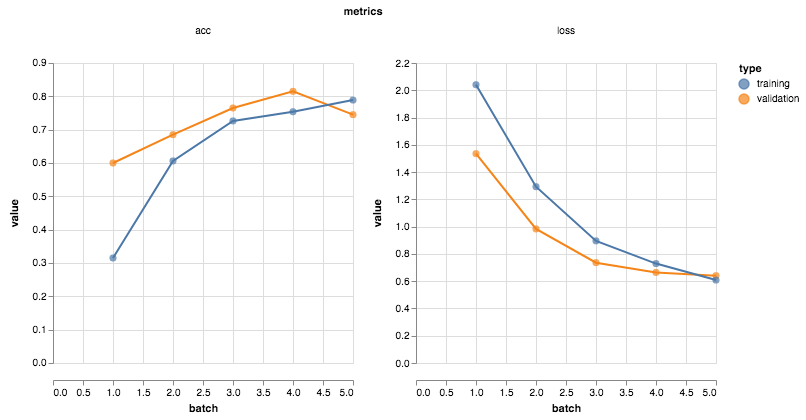

In [24]:
vis.metrics(output_transfer.history)

In [25]:
score = model_transfer.evaluate(x_test_conv_reshape_vgg, y_test_class, verbose=1)

NameError: name 'x_test_conv_reshape_vgg' is not defined

In [ ]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

**Step 5: Make & Visualise the Prediction**

In [ ]:
predict_classes_transfer = model_transfer.predict_classes(x_test_conv_reshape_vgg)

In [ ]:
pd.crosstab(y_test, predict_classes_transfer)

In [ ]:
proba_transfer = model_transfer_conv.predict_proba(x_test_conv_reshape_vgg)

In [ ]:
vis.imshow(x_test[i], labels[y_test[i]]) | vis.predict(proba_transfer[i], y_test[i], labels)